In [1]:
import torch
import numpy as np
import mediapy
import pickle
import torch
from scipy.io import savemat
import argparse
from tqdm import tqdm
from auxiliar.tracking_viz import generate_frame_image_cv

import matplotlib.pyplot as plt
from src.ortho_factorization import marques_factorization
import rerun as rr
from src.mat_compl import alternating_matrix_completion

%load_ext autoreload
%autoreload 2


In [2]:
import cv2 as cv
from auxiliar.read_video import read_video_or_images
from src.tapnext_infer import init_tapnext

tapnext_model_video_size = (256, 256)
device = "cuda:0"

#path = "../mast3r/images_in/casa_bea_4_photos"
path = "../mast3r/images_in/casa_bea_4_photos"
path = "../mast3r/images_in/lixo_lab.mp4"
#video_resized, video = read_video_or_images("../mast3r/images_in/bordalo.mp4",model_video_size, device)

video_square, _ = read_video_or_images(path)
print(video_square.shape)
torch.cuda.empty_cache()

/home/manuelf/miniconda3/envs/trackers/lib/python3.11/site-packages/torch/_export/utils.py:415: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _register_pytree_node(
Reading video: lixo_lab.mp4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:01<00:00, 114.40frame/s]


torch.Size([115, 518, 518, 3])


In [3]:
# Design the query points array in the original video size
step = 40
ys, xs = np.meshgrid(np.linspace(8, video_square[0].shape[0]-1, step), np.linspace(8, video_square[0].shape[1]-1, step))
query_points_initial = torch.tensor(
    np.stack(
    [np.zeros(len(xs.flatten())), xs.flatten(), ys.flatten()], axis=1
)[None],dtype=torch.float32).to(device)

#creata tensors for the video information
frame_cut = max(20, len(video_square))
#frame_cut = 106
frame_skip = 7
video_tensor = torch.cat([(frame).unsqueeze(0) for frame in video_square]).unsqueeze(0)[:,0:frame_cut:frame_skip,...] # 1, time, H, W, 3
video_tensor = torch.clip(video_tensor, -1, 1)
num_frames = video_tensor.shape[1]

print("frames:", num_frames)
torch.cuda.empty_cache()

frames: 17


In [4]:
from src.tapnext_infer import run_tapnext, init_alltracker
from src.new_queries import add_new_tracks
from auxiliar.read_video import resize_to_max_side
import utils.saveload
import utils.basic
import utils.improc
import torch.nn.functional as F

mode = "tapnext"  # choose: "alltracker", "tapnext", "cotracker"

match mode:
    # ==============================================================
    case "alltracker":

        model = init_alltracker(device)

        rgbs = resize_to_max_side((video_tensor.permute(0,1,4,2,3) + 1) / 2 * 255)
        B, T, C, H, W = rgbs.shape
        
        flows_e, visconf_maps_e, _, _ = model.forward_sliding(
            rgbs[:, 0:], iters=4, sw=None, is_training=False
        )

        # grid in pixel coords
        grid_xy = utils.basic.gridcloud2d(1, H, W, norm=False, device="cpu").float()  # [1,H*W,2]
        grid_xy = grid_xy.permute(0, 2, 1).reshape(1, 1, 2, H, W)  # [1,1,2,H,W]

        # flows_e: [1, T, 2, H, W]
        # grid_xy: [1, 1, 2, H, W]
        traj_maps_e = flows_e + grid_xy  # [1, T, 2, H, W]

        # → [1, T, H, W, 2]
        traj_maps_e = traj_maps_e.permute(0, 1, 3, 4, 2)

        # get forward visibility confidence (channel 1)
        vis_forward = visconf_maps_e[:, :, 1, :, :]  # [1, T, H, W]

        # apply a threshold (e.g. > 0.5)
        visible_mask = vis_forward > 0.75             # [1, T, H, W]
        visible_mask = visible_mask.unsqueeze(-1)    # [1, T, H, W, 1]
        visible_mask = visible_mask.expand_as(traj_maps_e)  # [1, T, H, W, 2]

        traj_maps_e[~visible_mask] = float('nan')


        # get original video shape
        H_orig, W_orig = video_tensor.shape[2:4]
        scale_x = W_orig / W  # width ratio
        scale_y = H_orig / H  # height ratio
        scale = torch.tensor([scale_x, scale_y], device=traj_maps_e.device)

        # apply before flattening
        traj_maps_e = traj_maps_e * scale

        # flatten to [1, T, H*W, 2]
        output_tensor = traj_maps_e.reshape(1, traj_maps_e.shape[1], H * W, 2)  # [1, T, N, 2]

    # ==============================================================
    case "tapnext":
        
        tapnext = init_tapnext(device, "/home/manuelf/storage/bootstapnext_ckpt.npz")
        print("Model initialized")

        video_permuted = video_tensor.clone().permute(0, 4, 1, 2, 3) 
        target_frames = video_permuted.shape[2] # Keep frames as 17
        target_height = 256
        target_width = 256
        resized_video = F.interpolate(
            video_permuted, 
            size=(target_frames, target_height, target_width), 
            mode='trilinear',  # Standard for 5D tensors
            align_corners=False
        )
        final_video = resized_video.permute(0, 2, 3, 4, 1)

        query_points_tapnext = query_points_initial.clone()
        query_points_tapnext[0, :, 1:3] /= torch.tensor([video_tensor.shape[3] / final_video.shape[3], video_tensor.shape[2] / final_video.shape[2]]).to(device) # 1, N, 3(frames,x,y)

        track_histories = run_tapnext(
            final_video.to(device),  # send the video resized to the model size
            query_points_tapnext,
            tapnext,
            device=device,
            new_tracks_flag=False,  # or None
        )
        output = {}

        for track_id, trajectory in tqdm(track_histories.items()):  # per feature
            coords = []
            for t in range(num_frames):  # per frame
                step = next((pos for (frame, pos) in trajectory if frame == t), None)
                coords.append(step if step is not None else torch.tensor([float('nan'), float('nan')]))
            output[track_id] = torch.stack(coords)  # shape: [num_frames, 2]

        output_list = [trajectory.unsqueeze(0) for _, trajectory in output.items()]
        output_tensor = torch.cat(output_list, dim=0).unsqueeze(0).permute(0, 2, 1, 3)  # [1, num_frames, num_feats, 2]

        # Flip x/y and scale back to original video size
        output_tensor = output_tensor[:, :, :, [1, 0]]
        output_tensor *= torch.tensor([
            video_tensor.shape[3] / final_video.shape[3],
            video_tensor.shape[2] / final_video.shape[2]
        ])

        torch.cuda.empty_cache()

    # ==============================================================
    case "cotracker":
        cotracker = torch.hub.load("facebookresearch/co-tracker", "cotracker3_offline").to(device)

        pred_tracks, pred_visibility = cotracker(
            video_tensor.squeeze().permute(0, 3, 1, 2).unsqueeze(0).float().to(device),
            grid_size=step,
            thr=0.9,
        )  # B T N 2,  B T N 1

        pred_tracks = pred_tracks.cpu()
        pred_visibility = pred_visibility.cpu()

        # Ensure shape [1, T, N, 1]
        if pred_visibility.ndim == 3:
            pred_visibility = pred_visibility.unsqueeze(-1)

        # Visibility mask
        visible_mask = pred_visibility.expand_as(pred_tracks)
        pred_tracks_masked = pred_tracks.clone()
        pred_tracks_masked[~visible_mask] = float('nan')

        # Optional flip if you want consistency
        # pred_tracks_masked = pred_tracks_masked[:, :, :, [1, 0]]

        output_tensor = pred_tracks_masked  # [1, num_frames, num_feats, 2]
        torch.cuda.empty_cache()

    # ==============================================================
    case _:
        raise ValueError(f"Unknown tracking mode: {mode}")

# Unified final output: output_tensor → shape [1, num_frames, num_feats, 2]
torch.cuda.empty_cache()


Model initialized


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1600/1600 [00:00<00:00, 29096.80it/s]


In [5]:

frame_cut_out = output_tensor.shape[1]

# Calculate the number of visible frames for each track
visible_counts = torch.sum(~torch.isnan(output_tensor[0, :frame_cut_out, :, 0]), dim=0) #shape: #feats

# Filter tracks that are visible for at least 20 frames
visible_tracks_mask = visible_counts >= 1
output_tensor_filtered = output_tensor[:, :frame_cut_out, visible_tracks_mask, :]
output_tensor_filtered.shape

video_tensor_original = video_tensor.to("cpu")

torch.cuda.empty_cache()

In [211]:
output_tensor.shape

torch.Size([1, 17, 1600, 2])

In [214]:
generate_frame_image_cv(video_tensor_original.cpu(), output_tensor[:,:,::3,:])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 12.64it/s]


In [6]:
import torch
import matplotlib.pyplot as plt
from src.interpolations import get_rgb_at_coords_torch

# output_tensor_filtered: [1, num_frames, num_feats, 2]
num_frames = output_tensor_filtered.shape[1]
num_feats = output_tensor_filtered.shape[2]

# Build observation matrix: [feats*2, frames]
obs_mat_full = torch.full((num_frames * 2, num_feats), float("nan"), device=output_tensor_filtered.device)

for frame in range(num_frames):  # per frame
    obs_mat_full[frame*2, :] = output_tensor_filtered[0, frame, :, 0]  # x
    obs_mat_full[frame*2+1, :] = output_tensor_filtered[0, frame, :, 1]  # y

# remove columns (features) that have any NaN values
valid_columns_mask_no_nan = ~torch.isnan(obs_mat_full).any(dim=0)
obs_mat = obs_mat_full[:, valid_columns_mask_no_nan]

# subsample columns (features) by a factor of 50
#obs_mat = obs_mat[:, ::10]

# remove columns with more than ~50% NaN values
nan_counts = torch.isnan(obs_mat_full).sum(dim=0)
valid_columns_mask_half = nan_counts < (obs_mat_full.shape[0] / 1.3)
obs_mat_half_missed = obs_mat_full[:, valid_columns_mask_half]

# percentage of missing values
missing_percentage = (
    torch.isnan(obs_mat_half_missed).sum().float()
    / (obs_mat_half_missed.numel())
    * 100
).item()

print(f"Percentage of missing values: {missing_percentage:.2f}%")

# plot with torch → numpy just for visualization
#plt.figure(figsize=(12, 6))
#plt.imshow((obs_mat_half_missed), aspect="auto", cmap="gray" )
#plt.show()

Percentage of missing values: 16.99%


Selected features: [3, 9, 185, 600, 116, 166, 636, 203, 0, 294, 753, 622, 248, 100, 868, 649, 282, 52, 659, 356, 116, 305]


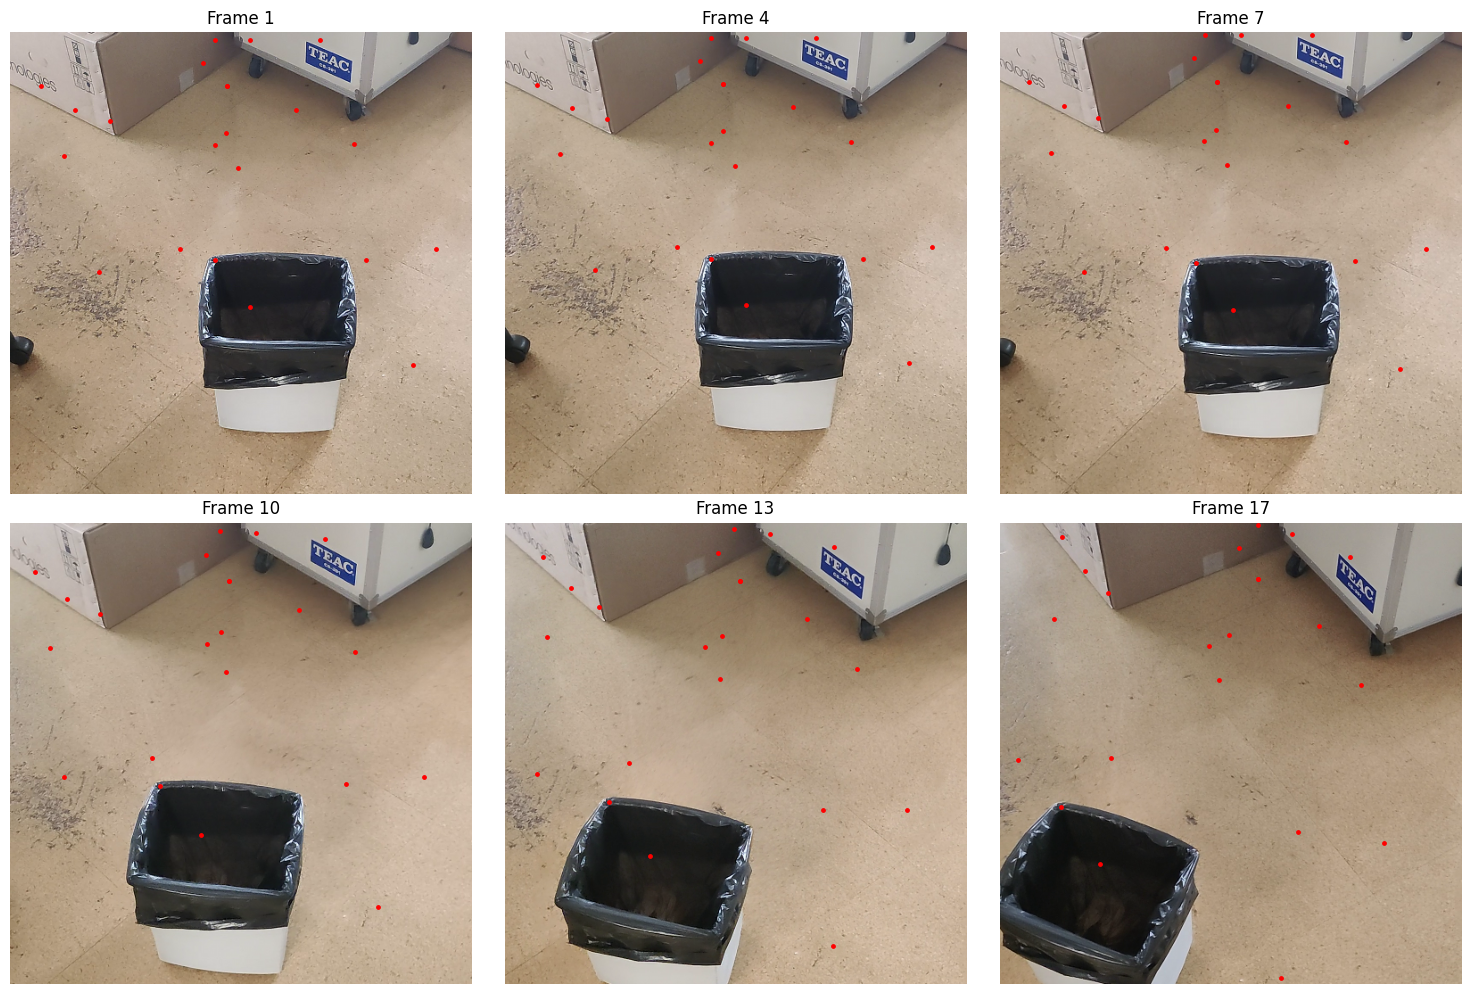

In [75]:
import torch
import matplotlib.pyplot as plt

# obs_mat: [2*frames, feats]
# video: [frames, H, W, C] in [-1, 1] (assumed)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Create a 2x3 grid
axes = axes.flatten()

# Predefined features (convert to torch if you want consistency)
features = torch.tensor([3, 9, 315, 227, 266, 207, 107])
features = torch.tensor([3, 9])
rand_feats = torch.randint(0, obs_mat.shape[1], (20,))

features = torch.cat([features, rand_feats])
print("Selected features:", features.tolist())

# Loop through frames
cnt = 0
for i in torch.linspace(0, video_tensor.cpu().shape[1]-1, 6).to(torch.int):  # num_frames
    # Convert frame for plotting
    frame_img = ((video_tensor[0,i].cpu() + 1) / 2.0)
    axes[cnt].imshow(frame_img)

    axes[cnt].scatter(obs_mat[i*2, features], obs_mat[i*2+1, features], s=6, c="red")
    axes[cnt].set_title(f"Frame {i+1}")
    axes[cnt].axis("off")
    cnt += 1

plt.tight_layout()
plt.show()


  0%|                                                                                                                                                                             | 0/200 [00:00<?, ?it/s]

Outer Iterations: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 331.94it/s]


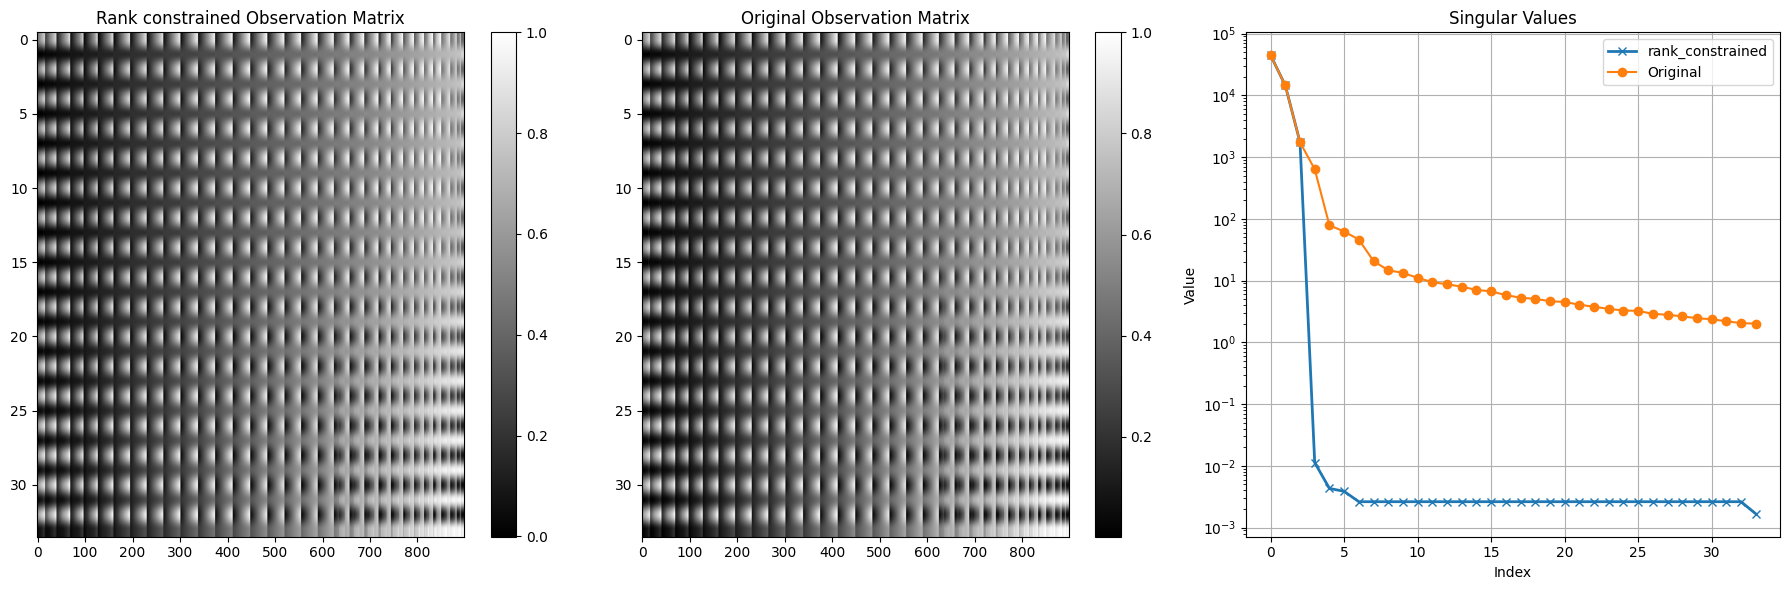

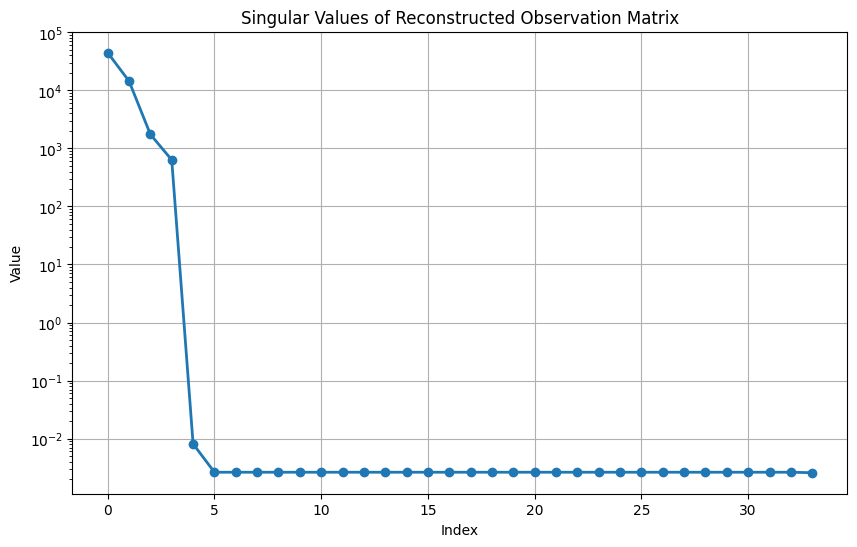

In [77]:
from src.ortho_factorization import costeira_marques
import torch.nn.functional as F


obs_completed, _ = alternating_matrix_completion(obs_mat, mode=0, max_iters=200, rank=3)
# completion + factorization
motion, shape, t,_ = costeira_marques(obs_mat) # rank 3
reconstructed_obs = motion @ shape + t.repeat(1, shape.shape[1])

plt.figure(figsize=(18, 6))

# Plot the completed observation matrix
plt.subplot(1, 3, 1)
plt.imshow(obs_completed / np.nanmax(obs_completed), aspect='auto', cmap='gray')
plt.title("Rank constrained Observation Matrix")
plt.colorbar()

# Plot the original observation matrix
plt.subplot(1, 3, 2)
plt.imshow(obs_mat / np.nanmax(obs_mat), aspect='auto', cmap='gray')
plt.title("Original Observation Matrix")
plt.colorbar()

# Plot the singular values
plt.subplot(1, 3, 3)
singular_values_rank = torch.linalg.svd(obs_completed, full_matrices=False).S
plt.plot(singular_values_rank.cpu().numpy(), "-x", linewidth=2)

singular_values_original = torch.linalg.svd(obs_mat, full_matrices=False).S
plt.plot(singular_values_original.cpu().numpy(), "-o")
plt.legend(["rank_constrained", "Original"])
plt.title("Singular Values")
plt.yscale("log")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()


#plot the singular values of the reconstructed
plt.figure(figsize=(10, 6))
singular_values_reconstructed = torch.linalg.svd(reconstructed_obs, full_matrices=False).S
plt.plot(singular_values_reconstructed.cpu().numpy(), "-o", linewidth=2)
plt.yscale("log")
plt.title("Singular Values of Reconstructed Observation Matrix")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()


In [ ]:
from auxiliar.depth_tensor_viz import k3d_3d_plot
k3d_3d_plot(shape.cpu().numpy())

In [79]:
import grpc
import os
import sys
import json

sys.path.append('../boxes/vggt/protos')
import pipeline_pb2 as vggt_pb2
import pipeline_pb2_grpc as vggt_pb2_grpc
from aux import wrap_value, unwrap_value
from PIL import Image
import io

image_byte_list = []
# List all files in the directory
if 0:
    
    files = [os.path.join(path, file) for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))]

    for file in sorted(files):
        # Open the file in binary read mode ('rb') and read its entire content
        with open(file, 'rb') as f:
            image_bytes = f.read()
            image_byte_list.append(image_bytes)
            print(f"Read {file}: {len(image_bytes) / (1024 * 1024):.2f} MB")

else:

    # Convert video frames (tensor) to a list of byte arrays
    for frame in video_tensor[0]:  # Assuming video_tensor_original is [1, time, H, W, C]
        # Convert tensor to numpy array and scale to [0, 255]
        frame_np = (frame.numpy() * 255).astype('uint8')
        # Create an Image object
        img = Image.fromarray(frame_np)
        # Save the image to a bytes buffer
        buffer = io.BytesIO()
        img.save(buffer, format="JPEG")
        # Append the bytes to the list
        image_byte_list.append(buffer.getvalue())

config_json = {
        "command": "3d_infer",
        "parameters": {
            "device": "cpu", # TODO: implement this
            "conf_vis": 50.0
        }
}

request = vggt_pb2.Envelope(data={"images":wrap_value(image_byte_list)},
                            config_json = json.dumps(config_json))
channel_opt = [('grpc.max_send_message_length', -1), ('grpc.max_receive_message_length', -1)]
channel=grpc.insecure_channel("localhost:8061",options=channel_opt)
estimator_stub = vggt_pb2_grpc.PipelineServiceStub(channel)
response = estimator_stub.Process(request)
channel.close()

#write the glb as a file
glb_file = unwrap_value(response.data["glb_file"])
with open("output.glb", "wb") as f:
    f.write(glb_file)
    

In [80]:
from auxiliar.depth_tensor_viz import k3d_3d_plot, plot_depth_tensor_grid
wrld_pts = np.load(io.BytesIO(unwrap_value(response.data["world_points"]))).squeeze().reshape(-1,3)
wrld_conf = np.load(io.BytesIO(unwrap_value(response.data["world_points_conf"]))).squeeze().reshape(-1,1)
                    
k3d_3d_plot(wrld_pts[wrld_conf.flatten() > 1, :][::100].T)

Output()

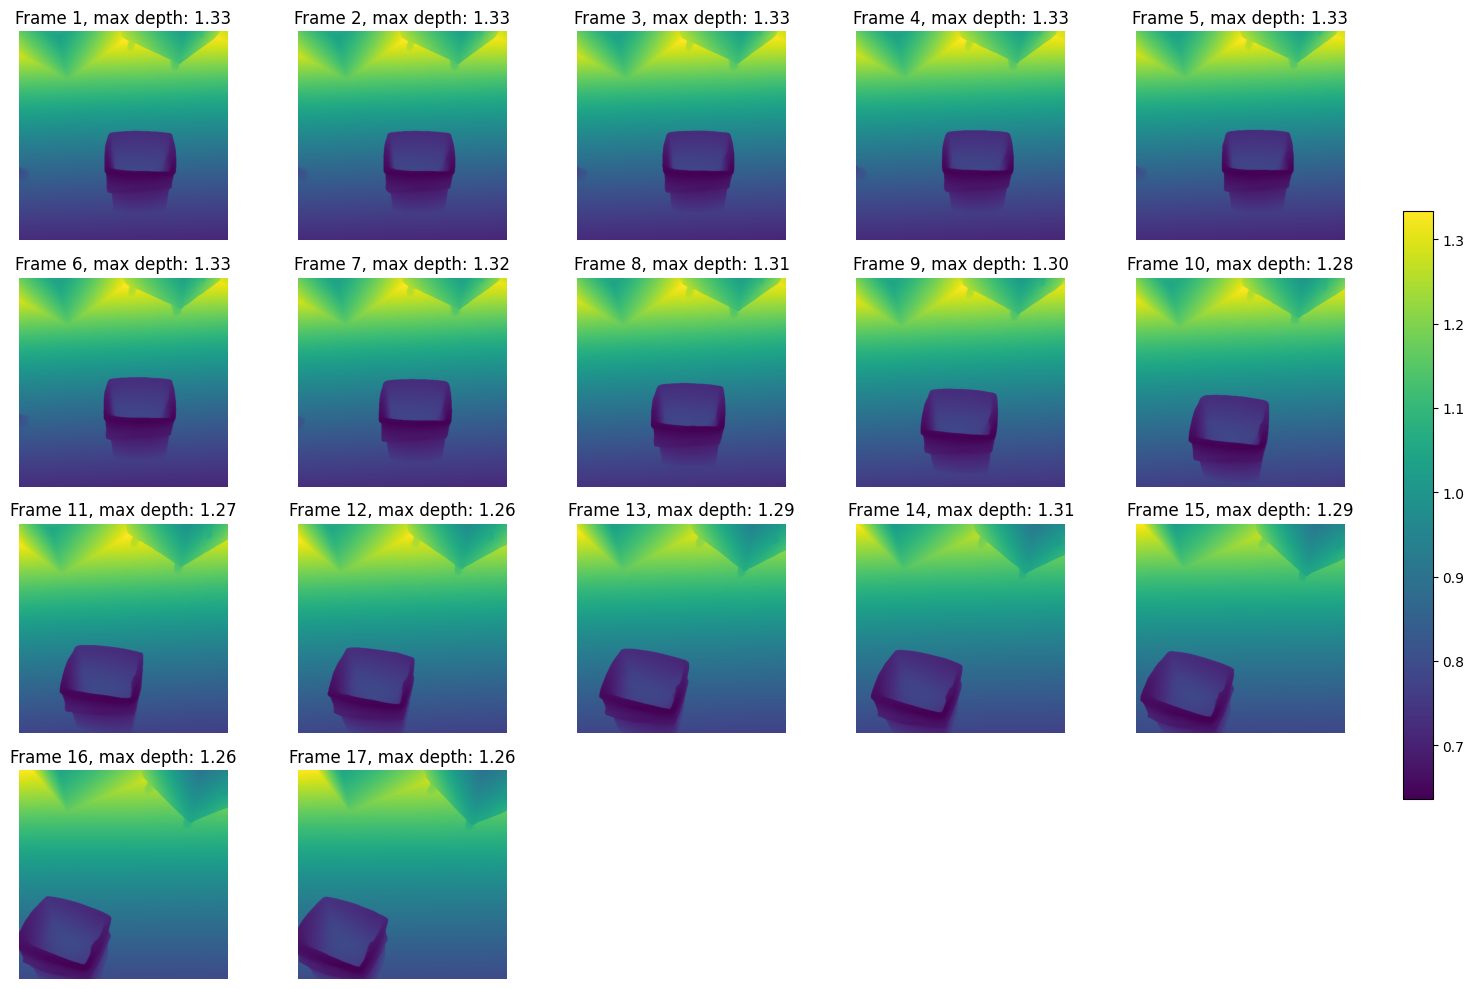

(<Figure size 1500x1000 with 21 Axes>,
 array([<Axes: title={'center': 'Frame 1, max depth: 1.33'}>,
        <Axes: title={'center': 'Frame 2, max depth: 1.33'}>,
        <Axes: title={'center': 'Frame 3, max depth: 1.33'}>,
        <Axes: title={'center': 'Frame 4, max depth: 1.33'}>,
        <Axes: title={'center': 'Frame 5, max depth: 1.33'}>,
        <Axes: title={'center': 'Frame 6, max depth: 1.33'}>,
        <Axes: title={'center': 'Frame 7, max depth: 1.32'}>,
        <Axes: title={'center': 'Frame 8, max depth: 1.31'}>,
        <Axes: title={'center': 'Frame 9, max depth: 1.30'}>,
        <Axes: title={'center': 'Frame 10, max depth: 1.28'}>,
        <Axes: title={'center': 'Frame 11, max depth: 1.27'}>,
        <Axes: title={'center': 'Frame 12, max depth: 1.26'}>,
        <Axes: title={'center': 'Frame 13, max depth: 1.29'}>,
        <Axes: title={'center': 'Frame 14, max depth: 1.31'}>,
        <Axes: title={'center': 'Frame 15, max depth: 1.29'}>,
        <Axes: title={'ce

In [81]:
plot_depth_tensor_grid(torch.tensor(np.load(io.BytesIO(unwrap_value(response.data["depth"])))))

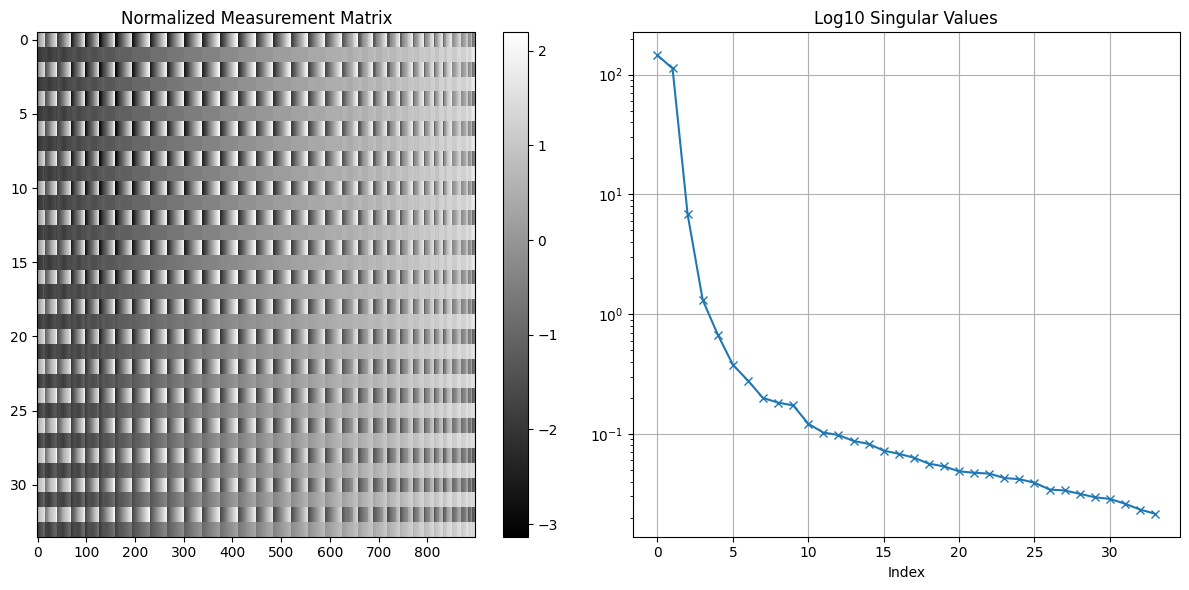

In [ ]:
import io
from src.projective_factorization import build_depth_weighted_matrix

vggt_depth_tensor = torch.tensor(np.load(io.BytesIO(unwrap_value(response.data["depth"]))))  # 1, time, H, W, 1
vggt_conf_tensor = torch.tensor(np.load(io.BytesIO(unwrap_value(response.data["depth_conf"]))))  # 1, time, H, W, 1
instrisics = torch.tensor(np.load(io.BytesIO(unwrap_value(response.data["intrinsic"]))))
extrinsics = torch.tensor(np.load(io.BytesIO(unwrap_value(response.data["extrinsic"]))))
wrld_pts = torch.tensor(np.load(io.BytesIO(unwrap_value(response.data["world_points"])))) # 1, #frame, H, W, 3

# need to resize the observation matrix to the size of the depth tensor
W_vggt = obs_mat.clone()
W_vggt[0::2,:] *=  (vggt_depth_tensor.shape[2] / video_tensor.shape[2])
W_vggt[1::2,:] *=  (vggt_depth_tensor.shape[3] / video_tensor.shape[3])

# average all intrinsic matrices
K_vggt = torch.mean(instrisics, dim=0) # TODO: this needs to be resized due to the tracks
#K = torch.eye(3)

frames_to_use = vggt_depth_tensor.shape[1]
W_depth_vggt, tracks_lambda_vggt, T, vggt_rays_norm = build_depth_weighted_matrix(W_vggt, vggt_depth_tensor.squeeze(),
                                            Ks=instrisics)


U, S, Vh = torch.linalg.svd(W_depth_vggt, full_matrices=False)
r = 4
Ur = U[:, :r]
Sr = torch.diag(S[:r])
Vr = Vh[:r, :]

Ssqrt = torch.linalg.cholesky(Sr)  
Motion = Ur @ Ssqrt                     
Sshape = Ssqrt @ Vr                # (4,  P) 
W_hat = Motion @ Sshape

#X3d = Sshape[:3, :] / Sshape[3:4, :]
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the normalized measurement matrix
im1 = axes[0].imshow(W_depth_vggt, aspect='auto', cmap='gray', interpolation='none')
axes[0].set_title("Normalized Measurement Matrix")
fig.colorbar(im1, ax=axes[0])

# Plot the singular values in log scale
axes[1].plot(torch.linalg.svd(W_depth_vggt)[1], "-x")
axes[1].set_xlabel("Index")
axes[1].set_title("Log10 Singular Values")
axes[1].set_yscale('log')
axes[1].grid(True)

plt.tight_layout()
plt.show(fig)


# Factorization of the W_hat with the no homogenous coordinates and the lambda

In [ ]:
from src.projective_factorization import metric_upgrade_daq
U, S, V = torch.linalg.svd(W_depth_vggt)

r = 4
Ur = U[:, :r]
Sr = torch.diag(S[:r])
Vr = Vh[:r, :]

Ssqrt = torch.linalg.cholesky(Sr)  
Motion = Ur @ Ssqrt                     
Shape = Ssqrt @ Vr

H, P_e, R_list, t_list = metric_upgrade_daq(Motion, [K_vggt for _ in range(W_depth_vggt.shape[0] // 3)])

X_e = H @ Shape       # Shape = 4×P from your projective factorization
X_e = X_e / X_e[3]
theta = lambda R :torch.arccos(((torch.trace(R) - 1) / 2).clamp(-1, 1))
R_norm = [theta(R) for R in R_list]
R_norm

# Another depth estimator model

In [84]:
import sys 
sys.path.append("/home/manuelf/UniDepth/")
from unidepth.models import UniDepthV2

device = "cpu"
model = UniDepthV2.from_pretrained("lpiccinelli/unidepth-v2-vitl14").to(device) # or "lpiccinelli/unidepth-v1-cnvnxtl" for the ConvNext backbone


Not loading pretrained weights for backbone
EdgeGuidedLocalSSI reverts to a non cuda-optimized operation, you will experince large slowdown, please install it:  `cd ./unidepth/ops/extract_patches && bash compile.sh`


In [85]:
depths = []
uni_conf = []
uni_focal = []

for frame in tqdm(range(video_tensor.shape[1])):
    pred = model.infer(video_tensor[0,frame].permute(2,0,1).to(device))
    #rnd = torch.rand(1).to(device) * 100
    rnd = 1
    #print(rnd)
    depths.append(pred["depth"] * rnd)
    uni_conf.append(1 / pred["confidence"])
    uni_focal.append(pred["intrinsics"])

uni_depth_tensor = torch.stack(depths).unsqueeze(-1).cpu().squeeze()  # (num_frames, H, W, 1)
uni_conf_tensor = torch.stack(uni_conf).unsqueeze(-1).cpu().squeeze()  # (num_frames, H, W, 1)
uni_focal_tensor = torch.stack(uni_focal).cpu().squeeze()  # (num_frames, 3, 3)
torch.cuda.empty_cache()

  0%|                                                                                                                                                              | 0/17 [00:00<?, ?it/s]/home/manuelf/UniDepth/unidepth/models/unidepthv2/unidepthv2.py:262: UserWarning: !! self.resolution_level not set, using default bounds !!
  warnings.warn("!! self.resolution_level not set, using default bounds !!")
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.15s/it]


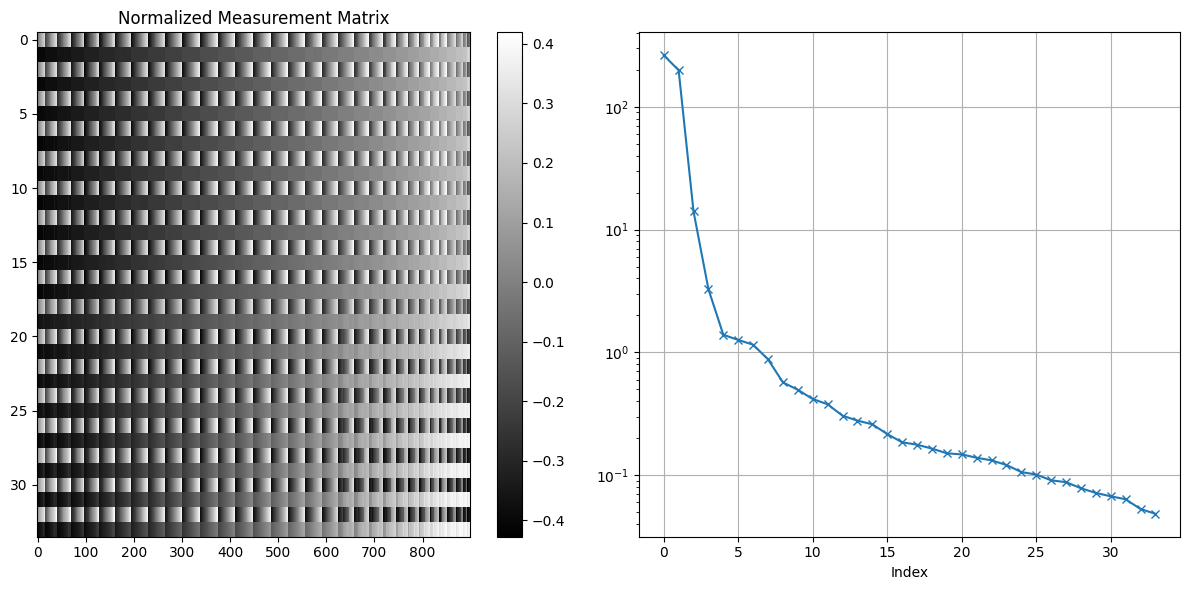

In [1115]:
from src.projective_factorization import build_depth_weighted_matrix

# make the tracks fit into the new depth size
W_uni = obs_mat.clone()
W_uni[0::2,:] = W_uni[0::2] * (uni_depth_tensor.shape[1] / video_tensor.shape[2])
W_uni[1::2,:] = W_uni[1::2] * (uni_depth_tensor.shape[2] / video_tensor.shape[3])

W_depth_uni, tracks_lambda_unidepth, T, uni_rays = build_depth_weighted_matrix(W_uni, uni_depth_tensor,
                                            uni_focal_tensor) 

# make tracks_lambda_unidepth be relative depth instead of metric depth
#tracks_lambda_unidepth = torch.stack([tracks_lambda_unidepth[f, :] /tracks_lambda_unidepth[f, :].max() for f in range(tracks_lambda_unidepth.shape[0])])

#pattern = torch.tensor([1, 1, 0], dtype=torch.bool)
#mask = pattern.repeat((W_depth_uni.shape[0] + len(pattern) - 1) // len(pattern))[:W_depth_uni.shape[0]]
#W_uni_nohomg = W_depth_uni[mask, ...]

U, S, Vh = torch.linalg.svd(W_depth_uni, full_matrices=False)
r = 4
Ur = U[:, :r]
Sr = torch.diag(S[:r])
Vr = Vh[:r, :]

Ssqrt = torch.linalg.cholesky(Sr)  
Motion = Ur @ Ssqrt                     
Sshape = Ssqrt @ Vr                # (4,  P) 
W_hat = Motion @ Sshape

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the normalized measurement matrix
im1 = axes[0].imshow(uni_rays, aspect='auto', cmap='gray', interpolation='none')
axes[0].set_title("Normalized Measurement Matrix")
fig.colorbar(im1, ax=axes[0])

# Plot the singular values in log scale
axes[1].plot(torch.linalg.svd(W_depth_uni)[1], "-x")
axes[1].set_xlabel("Index")
#axes[1].set_title("Log10 Singular Values")
axes[1].set_yscale('log')
axes[1].grid(True)

plt.tight_layout()
plt.show(fig)

In [ ]:
from auxiliar.depth_tensor_viz import k3d_3d_plot
k3d_3d_plot(marques_factorization(W_uni)[2]) # tomasi
#k3d_3d_plot(marques_factorization(W_depth_uni[:-1,:])[2]) # tomasi
#plt.imshow(costeira_marques(W_uni_nohomg)[1], aspect='auto', cmap='gray')


# AFFINE CAMERAS

In [ ]:
from src.ortho_factorization import calibrate_orthographic, random_camera

F, P = 6, 100

# Generate points on a sphere
# Generate uniformly distributed points on a sphere using Fibonacci sphere
indices = torch.arange(0, P, dtype=torch.float32)
phi = torch.acos(1 - 2 * (indices + 0.5) / P)  # polar angle
theta = torch.pi * (1 + 5**0.5) * indices  # golden angle increment

radius = 1.0  # unit sphere

x = radius * torch.sin(phi) * torch.cos(theta)
y = radius * torch.sin(phi) * torch.sin(theta)
z = radius * torch.cos(phi)

shape = torch.stack([x, y, z], dim=0)
shape = torch.cat([shape, torch.ones(1, P)], dim=0)  # [4, P]
motion = torch.stack([random_camera(camera_type="affine") for _ in range(F)]).reshape(-1, 4)  # [2F, 4]
rand_lambda = (10.0 - 1.0) * torch.rand(F, P) + 1.0

#rand_lambda = torch.rand(F, P)
rand_W = (motion @ shape) / rand_lambda.repeat_interleave(2, dim=0)
rand_lambda_hat = rand_lambda.clone()

# add a random offset to each line of rand_lambda_hat
offsets_list = torch.tensor([torch.rand(1).item() * 2.0 for _ in range(F)])
for f in range(F):
    rand_lambda_hat[f, :] += offsets_list[f]

idx = 0
offsets_init = None 
scales_init = None

for max_percentage in np.logspace(-2, -2, 1):
    torch.manual_seed(2131)

    uniform_noise = (torch.rand_like(rand_lambda_hat) * 2.0 - 1.0)
    
    relative_error = uniform_noise * max_percentage
    
    noisy_lambda = rand_lambda_hat * (1.0 + relative_error)

    scales, offsets, W, first_W, z = calibrate_orthographic(
        rand_W, noisy_lambda, K=torch.rand(3,3),
        iters=40, rank=4, tol=1e-6, init_offsets=offsets_init, init_scales=scales_init
    )

    if idx == 0:
        offsets_init = offsets[-1].clone()
        scales_init = scales[-1].clone()

    new_shape = marques_factorization(W)[2]

    ones = torch.ones(P, 1, device=device)
    A = torch.cat([new_shape[:3,:].T, ones], dim=1) # Shape [P, 4] (Design Matrix)
    B = shape[:3,:].T  # Shape [P, 3] (Target Matrix)
    # T (4x3) that minimizes || A*T - B ||^2
    
    T_sol = torch.linalg.lstsq(A, B).solution
    S_rec_aligned = A @ T_sol
    error = torch.norm(B - S_rec_aligned) / 1
    print(error)

    plt.scatter(max_percentage, error.cpu(), c="blue")
    idx += 1
    
plt.xlabel("relative error in depth measurements")
plt.ylabel("Shape reconstruction error")
plt.xscale("log")
#plt.yscale("log")
#plt.ylim(0, 0.08)

plt.figure()
plt.plot(torch.linalg.svdvals(first_W)[:7], "-x", label="before")
plt.plot(torch.linalg.svdvals(W)[:7], "-x", label="after")
plt.yscale("log")
plt.legend()

fig, axs = plt.subplots(2, 1, figsize=(10,8), sharex=True)

num_iters, F = scales.shape
iters = torch.arange(num_iters)

# --- subplot 1: scales ---
for f in range(F):
    axs[0].plot(iters, scales[:, f].cpu(), "-o", label=f"frame {f}")

axs[0].set_ylabel("Scale d[f]")
axs[0].set_title("Per-frame scale convergence")
axs[0].grid(True)
axs[0].legend(ncol=3, fontsize=8)

# --- subplot 2: offsets ---
for f in range(F):
    axs[1].plot(iters, offsets[:, f].cpu(), "-o", label=f"frame {f}")
    axs[1].hlines(-offsets_list[f], -1, iters[-1])

axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Offset s[f]")
axs[1].set_title("Per-frame offset convergence")
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [995]:
T_sol.T

tensor([[ 5.3955e-01, -5.8435e-01,  6.1379e-01,  2.0189e-04],
        [ 2.6562e-01,  8.0483e-01,  5.3729e-01,  1.3255e-04],
        [-8.0449e-01, -1.2817e-01,  5.9090e-01,  6.1034e-09]])

In [ ]:
k3d_3d_plot([(A @ T_sol).T, shape[:3,:]])

In [ ]:
k3d_3d_plot(marques_factorization(motion@shape)[2])

# projective cameras

In [ ]:
from src.ortho_factorization import calibrate_orthographic, random_camera

F, P = 6, 600

# Generate points on a sphere
indices = torch.arange(0, P, dtype=torch.float32)
phi = torch.acos(1 - 2 * (indices + 0.5) / P)  # polar angle
theta = torch.pi * (1 + 5**0.5) * indices  # golden angle increment

radius = 1.0  # unit sphere

x = radius * torch.sin(phi) * torch.cos(theta)
y = radius * torch.sin(phi) * torch.sin(theta)
z = radius * torch.cos(phi)

shape = torch.stack([x, y, z], dim=0)
shape = torch.rand(3, P) * 2.0 - 1.0
shape = torch.cat([shape, torch.ones(1, P)], dim=0)  # [4, P]

camera_lists = [random_camera(camera_type="projective") for _ in range(F)]

P1_gt = camera_lists[0]
M1_gt = P1_gt[:, :3] 
inv_P1 = torch.eye(4)
inv_P1[:3, :3] = M1_gt.t()
inv_P1[:3, 3] = -(M1_gt.t() @ P1_gt[:, 3])

new_camera_lists = []
for cam in camera_lists:
    P_homog = torch.eye(4)
    P_homog[:3, :] = cam
    P_new = (P_homog @ inv_P1)[:3, :]
    new_camera_lists.append(P_new)
camera_lists = new_camera_lists

shape = (torch.linalg.inv(inv_P1) @ shape)
motion = torch.stack(camera_lists).reshape(-1, 4)  # [3F, 4]

rand_lambda = (10.0 - 1.0) * torch.rand(F, P) + 1.0 # between 1 and 10
rand_W = (motion @ shape) / rand_lambda.repeat_interleave(3, dim=0)

# check the rotatio from  matrix
M = motion[:3,:3]
M_flipped = torch.flip(M, dims=[0, 1]).T
Q_flipped, R_flipped = torch.linalg.qr(M_flipped)
R = torch.flip(Q_flipped.T, dims=[0, 1])
K = M @ R.T
d = torch.sign(torch.diag(K))
d[d == 0] = 1.0
D = torch.diag(d)
K = K @ D
R = D @ R
Kt = motion[:3, 3]
tvec = torch.linalg.inv(K) @ Kt

from src.projective_factorization import projective_factorization

M_est, S_est, T_est = projective_factorization(motion @ shape)
R1_est = M_est[:3, :3]   # Recovered R1
t1_est = T_est[:3]       # Recovered t1

S_aligned = R1_est @ S_est + t1_est
cam_lists_aligned = []
R1_inv = R1_est.t()

for frame in range(F):
    Mi = M_est[frame*3 : (frame+1)*3, :]
    ti = T_est[frame*3 : (frame+1)*3]
    
    # New orientation: Mi @ R1.T
    Mi_new = Mi @ R1_inv
    # New translation: ti - Mi_new @ t1
    ti_new = ti - (Mi_new @ t1_est)
    
    P_new = torch.cat((Mi_new, ti_new), dim=1)
    cam_lists_aligned.append(P_new)

# aligh S with the ground truth shape
#k3d_3d_plot(S_aligned, camera_input=cam_lists_aligned)

In [1117]:
#k3d_3d_plot([shape[:3,:]], camera_input=camera_lists)

In [1156]:
def make_homogenous(obs_mat):
    """
    Converts a 2F x P matrix to a 3F x P matrix by inserting 1s.
    
    Args:
        obs_mat: torch.Tensor of shape (2*F, P)
                 Structure: [x0, y0, x1, y1, ...]^T
    
    Returns:
        obs_homog: torch.Tensor of shape (3*F, P)
                   Structure: [x0, y0, 1, x1, y1, 1, ...]^T
    """
    F2, P = obs_mat.shape
    F = F2 // 2
    device = obs_mat.device
    dtype = obs_mat.dtype

    # 1. Reshape to separate frames: (F, 2, P)
    obs_reshaped = obs_mat.view(F, 2, P)

    # 2. Create a row of ones: (F, 1, P)
    ones = torch.ones((F, 1, P), device=device, dtype=dtype)

    # 3. Concatenate along the coordinate dimension: (F, 3, P)
    # Result per frame is [x, y, 1]
    obs_combined = torch.cat([obs_reshaped, ones], dim=1)

    # 4. Flatten back to (3*F, P)
    obs_homog = obs_combined.view(3 * F, P)

    return obs_homog

W_uni_homog = make_homogenous(uni_rays)
motion, shape, tvec = projective_factorization(new_lambda_uni.repeat_interleave(3,0) * W_uni_homog)

cam_lists = []
for frame in range(motion.shape[0] // 3):
    Mi = motion[frame*3 : (frame+1)*3, :]
    ti = tvec[frame*3 : (frame+1)*3]
    
    P = torch.cat((Mi, ti), dim=1)
    cam_lists.append(P)

k3d_3d_plot(shape[:3,:], camera_input=cam_lists)

Output()

In [312]:
frames_to_use = torch.arange(0, uni_depth_tensor.shape[0],5)
indices = torch.stack((frames_to_use * 2, frames_to_use * 2 + 1), dim=1).flatten()
print(frames_to_use)

scales, offsets, W, first_W, z = calibrate_orthographic(
    uni_rays_norm[indices], # Use the interleaved indices
    tracks_lambda_vggt[frames_to_use,:], 
    K=torch.eye(3),
    iters=1000, rank=5, tol=1e-8
)

plt.figure()
plt.plot(torch.linalg.svdvals(first_W)[:7], "-x", label="before")
plt.plot(torch.linalg.svdvals(W)[:7], "-x", label="after")
plt.yscale("log")
plt.legend()

fig, axs = plt.subplots(2, 1, figsize=(10,8), sharex=True)

num_iters, F = scales.shape
iters = torch.arange(num_iters)

# --- subplot 1: scales ---
for f in range(F):
    axs[0].plot(iters, scales[:, f].cpu(), "-o", label=f"frame {f}")

axs[0].set_ylabel("Scale d[f]")
axs[0].set_title("Per-frame scale convergence")
axs[0].grid(True)
axs[0].legend(ncol=3, fontsize=8)

for f in range(F):
    axs[1].plot(iters, offsets[:, f].cpu(), "-o", label=f"frame {f}")

axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Offset s[f]")
axs[1].set_title("Per-frame offset convergence")
axs[1].grid(True)

plt.tight_layout()
plt.show()

tensor([ 0,  5, 10, 15])


NameError: name 'uni_rays_norm' is not defined

# Tests

Text(0.5, 1.0, 'Singular Values Comparison VGGt vs UniDepth, normalized')

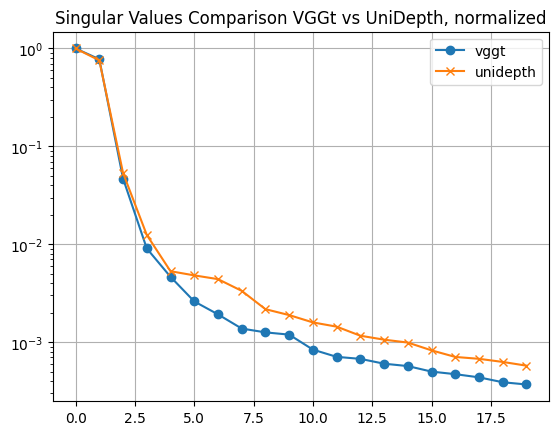

In [ ]:
s_vggt = torch.linalg.svdvals(W_depth_vggt)
plt.plot(s_vggt[:20] /  s_vggt[0], "-o", label="vggt")

s_unidepth = torch.linalg.svdvals(W_depth_uni)
plt.plot(s_unidepth[:20] / s_unidepth[0], "-x", label="unidepth")

plt.yscale("log")
plt.legend()
plt.grid()
plt.title("Singular Values Comparison VGGt vs UniDepth, normalized")

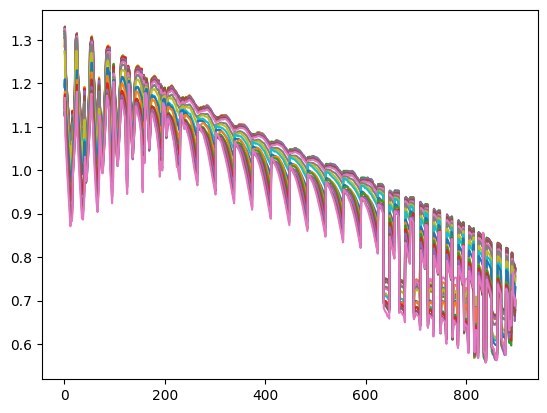

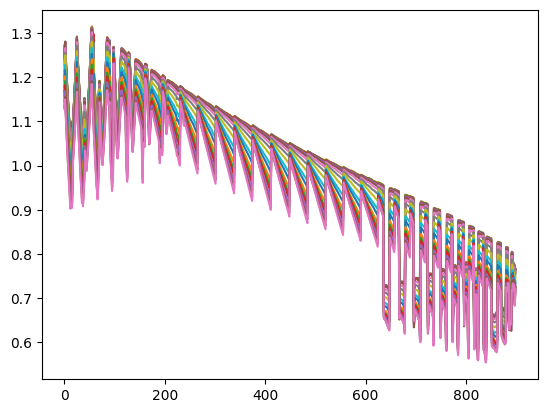

In [ ]:
for f in range(0,tracks_lambda_vggt.shape[0]):
    plt.plot((tracks_lambda_unidepth[f,:].cpu()- offsets[f])/scales[f], label=f"uni in vggt frame {f}")
#plt.legend()

plt.figure()
for f in range(tracks_lambda_vggt.shape[0]):
    plt.plot(tracks_lambda_vggt[f,:].flatten() , label=f"frame {f}")
#plt.legend()

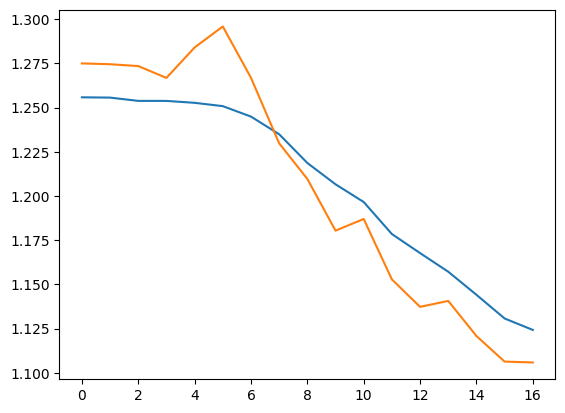

In [ ]:
plt.plot(tracks_lambda_vggt[:, 57].flatten() , label=f"vggt frame 0")
plt.plot(new_lambda_uni[:, 57].flatten() , label=f"vggt frame 0")

RMSE: 0.0215, correlation: 0.9976
RMSE: 0.0220, correlation: 0.9977
RMSE: 0.0270, correlation: 0.9971
RMSE: 0.0278, correlation: 0.9961
RMSE: 0.0268, correlation: 0.9957
RMSE: 0.0316, correlation: 0.9953
RMSE: 0.0241, correlation: 0.9972
RMSE: 0.0353, correlation: 0.9951
RMSE: 0.0233, correlation: 0.9969
RMSE: 0.0176, correlation: 0.9921
RMSE: 0.0254, correlation: 0.9969
RMSE: 0.0197, correlation: 0.9921
RMSE: 0.0194, correlation: 0.9917
RMSE: 0.0190, correlation: 0.9932
RMSE: 0.0210, correlation: 0.9920
RMSE: 0.0196, correlation: 0.9937
RMSE: 0.0268, correlation: 0.9948


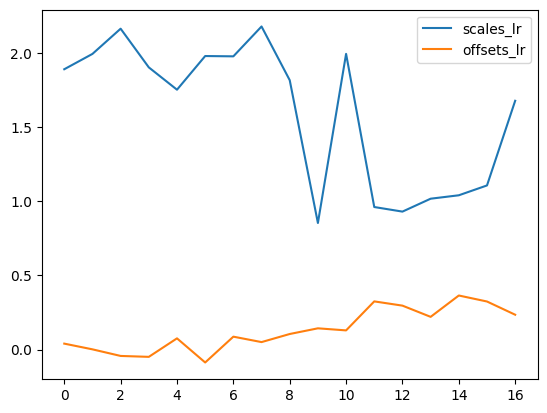

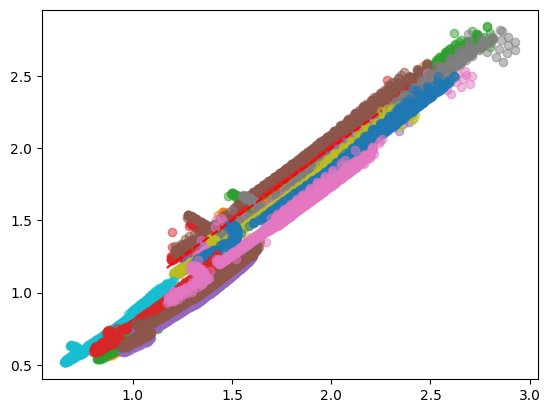

In [ ]:
%matplotlib inline

scales_lr = []
offsets_lr = []

for frame in range(tracks_lambda_vggt.shape[0]):
    x = tracks_lambda_vggt[frame, :].flatten()
    y = tracks_lambda_unidepth[frame, :].flatten()
    A = torch.stack([x, torch.ones_like(x)], dim=1)  # [N,2]
    sol = torch.linalg.lstsq(A, y.unsqueeze(1)).solution
    s, o = sol.squeeze()

    scales_lr.append(s.item())
    offsets_lr.append(o.item())

    y_pred = s * x + o
    residuals = y - y_pred
    rmse = torch.sqrt(torch.mean(residuals**2))
    corr = torch.corrcoef(torch.stack([x, y]))[0, 1]
    print(f"RMSE: {rmse.item():.4f}, correlation: {corr.item():.4f}")

    if 0:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Left subplot: Video frame with residuals overlay
        axes[0].imshow((video_tensor_original[0,frame] + 1) / 2)
        xs = obs_mat[frame * 2 + 0, :]
        ys = obs_mat[frame * 2 + 1, :]
        scatter = axes[0].scatter(xs.flatten(), ys.flatten(), c=np.abs(residuals.flatten()), cmap='hot', s=10)
        fig.colorbar(scatter, ax=axes[0], label='Residuals')
        axes[0].set_title("Residuals Visualization")

        # Right subplot: Residuals plot
        axes[1].plot(residuals.numpy(), label="Residuals")
        axes[1].set_title("Residuals Plot")
        axes[1].set_xlabel("Feature Index")
        axes[1].set_ylabel("Residual Value")
        axes[1].legend()

        plt.tight_layout()
        plt.show()

plt.plot(scales_lr, label="scales_lr")
plt.plot(offsets_lr, label="offsets_lr")
plt.legend()

# Final aligned depth comparison
plt.figure()
new_lambda_uni = torch.zeros_like(tracks_lambda_unidepth)
for frame in range(0,tracks_lambda_unidepth.shape[0]):

    #build new lambda matrix
    new_lambda_uni[frame,:] = (tracks_lambda_unidepth[frame, :] - offsets_lr[frame])/scales_lr[frame]

    x = tracks_lambda_vggt[frame, :].flatten()
    y = tracks_lambda_unidepth[frame, :].flatten()
    s = scales_lr[frame]
    o = offsets_lr[frame]
    y_aligned =   s* x
    plt.scatter(y.cpu(), y_aligned.cpu(), label="Original Depths", alpha=0.5)

plt.plot(np.linspace(y.min().item(), y.max().item(), 100), np.linspace(y.min().item(), y.max().item(), 100), 'r--', label="x = y")

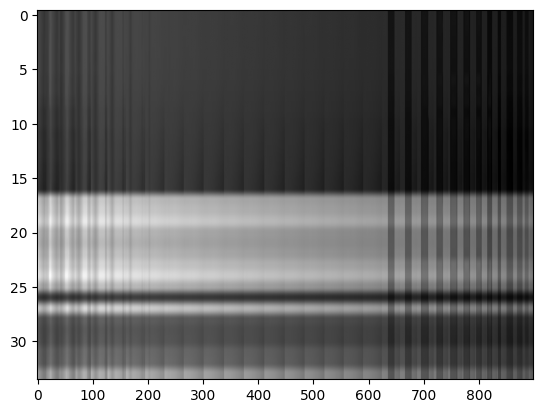

In [ ]:
plt.imshow(torch.cat((new_lambda_uni, tracks_lambda_unidepth),dim=0), aspect='auto', cmap='gray')

In [ ]:
k3d_3d_plot(marques_factorization(W_depth_vggt)[2])

Output()

In [ ]:
plt.imshow(tracks_lambda_vggt, aspect='auto', cmap='gray', interpolation='none')    
plt.colorbar()

In [ ]:
k3d_3d_plot(marques_factorization( new_lambda_uni.repeat_interleave(2,0) * W_uni )[2]) # tomasi

Output()

In [ ]:
from src.projective_factorization import sample_depths

def backproject_points(tracks, depths, Ks):
    """
    Backproject 2D points to 3D using per-frame intrinsics.

    Args:
        tracks: [2F, P] pixel coords (u, v interleaved per frame)
        depths: [F, P] sampled depths for each feature
        Ks: [F, 3, 3] Intrinsic matrices for each frame (or [1, 3, 3] for shared intrinsics)

    Returns:
        [F, P, 3] 3D points in camera coords per frame
    """
    F, P = depths.shape
    
    # Extract intrinsics and reshape to [F, 1] (or [1, 1]) for broadcasting
    fx = Ks[:, 0, 0].unsqueeze(1)
    fy = Ks[:, 1, 1].unsqueeze(1)
    cx = Ks[:, 0, 2].unsqueeze(1)
    cy = Ks[:, 1, 2].unsqueeze(1)

    # Separate u and v coordinates
    # tracks is [2F, P], so we slice stride 2 to get [F, P]
    u = tracks[0::2, :] 
    v = tracks[1::2, :]

    # Apply pinhole inverse projection
    # Shapes: ([F, P] - [F, 1]) / [F, 1] * [F, P]
    X = (u - cx) / fx * depths
    Y = (v - cy) / fy * depths
    Z = depths

    return torch.stack([X, Y, Z], dim=-1)  # [F, P, 3]

num_frames = uni_depth_tensor.shape[0]

tracks_depth = sample_depths(uni_depth_tensor[0:num_frames,...], W_uni[0:num_frames*2,...])  # [F, P]

pts = backproject_points(W_uni[0:num_frames*2,...], tracks_depth,
                          Ks=uni_focal_tensor)[0,...] # all frames

X,Y,Z = pts[:,0].cpu(), pts[:,1].cpu(), pts[:,2].cpu()

#use rerrun to see the pts
k3d_3d_plot(pts.T, scale=200)

Output()

In [ ]:
from auxiliar.depth_tensor_viz import plot_depth_tensor_grid
plot_depth_tensor_grid(uni_depth_tensor)

In [ ]:
# Find fundamental matrices between frames
from tqdm import tqdm

fig, axes = plt.subplots(3,2, figsize=(15, 10))  # Create a 2x3 grid
axes = axes.flatten()

for frame in range(obs_mat.shape[0] // 2 - 1):

    pts1 = obs_mat[frame*2:frame*2+2, :].T
    pts2 = obs_mat[(frame+8)*2:(frame+8)*2+2, :].T

    F, mask = cv.findFundamentalMat(
        pts1.cpu().numpy(), 
        pts2.cpu().numpy(), 
        cv.FM_RANSAC,
        ransacReprojThreshold=1.0)
    
    # show both imaegs side by side and represent the outliers
    img1 = ((video[frame] + 1) / 2.0)
    img2 = ((video[frame+8] + 1) / 2.0)
    combined_img = np.hstack((img1, img2))
    axes[frame].imshow(combined_img)

    for i in range(0, pts1.shape[0], 10):
        if mask[i]:
            color = 'g'  # Inlier
        else:
            color = 'r'  # Outlier
        axes[frame].scatter(pts1[i, 0], pts1[i, 1], s=6, c=color)
        axes[frame].scatter(pts2[i, 0] + img1.shape[1], pts2[i, 1], s=6, c=color)  # Offset x for second image
        axes[frame].set_title(f"Frame {frame+1} and {frame+2}")

    break  # only first pair for demo
